# Crude Palm Oil Spot Price Prediction with Multivariate LSTM Model

**Name** : Loke Jenn Hong  
**Github** : <https://github.com/jhloke-24/CPO-Price-Prediction>

**Summary** 

(1) Crude palm oil (CPO) spot price prediction is a **multivariate time-series** problem that can be solved by **long short-term memory (LSTM)** model, which is a deep learning algorithm leveraging on recurrent neural network.

(2) The model is evaluated goodness-of-fit and predictive power are evalaluated based on **Root Mean Square Error (RSME)**. This model serve as a preliminary model, future work to enhance the model performance includes (1) Hyper-parameter tuning. (2) Ingestion of daily data.

(3) Production will take place in Google Colab, which will create an API to grab the data source from Git Hub repositories and ultimately output the prediction result in Google Colab server. The implemented model can be retrieved below:

Google Lab Server : 

<https://colab.research.google.com/drive/1jog_Mk-V0Kznx7ohbI2Z_k8FVWmFvZeb#scrollTo=iGyKN1h_VMqa>

Import crude palm oil (CPO) spot price data with other predictive factors including soybean, crude & gas oil price, USD-MYR exchange rate, ONI Index, and palm oil inventory data, and define data type, remove blank, rearrange feature columns etc.

In [11]:
import os
import pandas as pd
import numpy as np

df = pd.read_csv("Assignment-monthlyexcerpt.csv")

#Drop blank rows & columns imported from the csv file
df2 = df.dropna(axis=0,how="all")
df3 = df2.dropna(axis=1,how="all")

#Drop repeting date columns
df4 = df3.iloc[1: , [0,1,3,5,7,9,11,13,15]]

#Rename the fields
df5a = df4.rename(columns= {'BO1 Comdty':'DATE', 'CBOT Soybean Oil Future':'SBO', 
                           'ICE Brent Crude Oil Future':'CO','ICE Gas Oil Future':'GO',
                           'Crude Palm Oil fob Spot':'CPO','US DOLLAR/MALAYSIAN RINGGIT':'USD',
                           'NOAA Oceanic Nino Index ONI':'ONI','Total Palm Oil Inventory Data':'POI',
                           'DOLLAR INDEX SPOT':'DIS'})

from datetime import datetime

df5a['DATE2'] = None
for i in df5a.index:
    df5a['DATE2'][i] = datetime.strptime(df5a['DATE'][i], '%d-%m-%y').date()
    
df5 = df5a.set_index("DATE2")
df5 = df5.drop(columns=['DATE'])
df6 = df5.apply(pd.to_numeric)
df7 = df6[['CPO', 'SBO', 'CO', 'GO','USD','ONI','POI','DIS']]

df7

,CPO,SBO,CO,GO,USD,ONI,POI,DIS
DATE2,,,,,,,,
2005-01-31,1332.95,19.77,44.48,392.61,3.8000,0.6,1514.016,83.119
2005-02-28,1316.34,20.11,45.86,408.81,3.8000,0.6,1536.907,83.721
2005-03-31,1428.14,23.31,53.27,481.50,3.8000,0.4,1437.493,82.887
2005-04-29,1433.85,22.62,53.31,486.35,3.8000,0.4,1488.828,84.267
2005-05-31,1413.84,22.79,49.67,447.86,3.8000,0.3,1295.309,85.684
...,...,...,...,...,...,...,...,...
2017-08-31,2647.61,33.92,51.87,481.77,4.2842,-0.1,1941.717,93.175
2017-09-29,2776.75,34.32,55.51,530.50,4.2082,-0.4,2015.922,92.343
2017-10-31,2742.70,33.71,57.65,531.15,4.2298,-0.7,2203.383,93.712


As part of EDA, plot the monthly historial price for crude palm oil from Jan'15 - Dec'17.

Text(0, 0.5, 'CPO Spot Price')

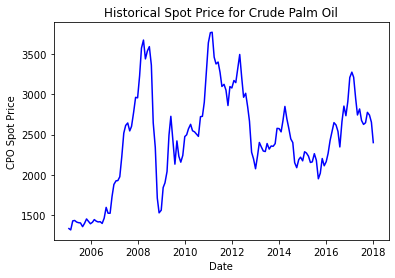

In [14]:
#Historical spot price for crude pal oil.
import matplotlib.pyplot as plt
plt.title('Historical Spot Price for Crude Palm Oil')
plt.plot(df6['CPO'],color='b')
plt.xlabel('Date')
plt.ylabel('CPO Spot Price')

In essence, the steps below do 3 things:

(1) Normalize the features and target variable to scale of (0,1) - This is to prevent the model feature dominants one another based on magnitute. 

(2) Split the data into train and test set in ratio of 8:2. 

(3) Reshape the data into readable input for LSTM model. We use past 3 months data (npast=3) to predict the SPO price. 

In [19]:
import math
from sklearn.preprocessing import MinMaxScaler

#Define train & test test with ratio of 8:2.
CPO_SPOT_VALUE = df6['CPO'].values
TRAIN_IND = math.ceil(len(CPO_SPOT_VALUE)* 0.8)

TRAIN = df7.iloc[:TRAIN_IND, :]
TEST = df7.iloc[TRAIN_IND:, :]

scaler = MinMaxScaler(feature_range=(0,1))

TRAIN_SCALED = scaler.fit_transform(TRAIN)
TEST_SCALED = scaler.fit_transform(TEST)

# Split into Train and Test set ; Data Preperation into LSTM format
def func(Data,npast):
    dataX = []
    dataY = []
         
    for i in range(npast,len(Data)):
        dataX.append(Data[i - npast:i, 0:Data.shape[1]])
        dataY.append(Data[i,0])
    return np.array(dataX),np.array(dataY)

#Use past 3 months data as prediction input
npast = 3
X_TRAIN, Y_TRAIN = func(TRAIN_SCALED,npast)   
X_TEST, Y_TEST = func(TEST_SCALED,npast) 
        
print("X_TRAIN Shape -- ",X_TRAIN.shape)
print("Y_TRAIN Shape -- ",Y_TRAIN.shape)

print("X_TEST Shape -- ",X_TEST.shape)
print("Y_TEST Shape -- ",Y_TEST.shape)

X_TRAIN Shape --  (122, 3, 8)
Y_TRAIN Shape --  (122,)
X_TEST Shape --  (28, 3, 8)
Y_TEST Shape --  (28,)


Fitting the data into LSTM model. Here we attempt to do hyper-parameter tuning by using Grid Search.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(5,return_sequences=True,input_shape=(npast,len(df7.columns))))
    grid_model.add(LSTM(5))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1)) 
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model 

grid_model = KerasRegressor(build_fn = build_model,verbose=1,validation_data=(X_TEST,Y_TEST))

parameters = {'batch_size' : [1,1],
              'epochs' : [1,1],
              'optimizer' : ['adam','Adadelta'] }

grid_search = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(X_TRAIN,Y_TRAIN)

grid_search.best_params_

LSTM = grid_search.best_estimator_.model

LSTM.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 3, 5)              280       
                                                                 
 lstm_101 (LSTM)             (None, 5)                 220       
                                                                 
 dropout_50 (Dropout)        (None, 5)                 0         
                                                                 
 dense_50 (Dense)            (None, 1)                 6         
                                                                 
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


Compare actual vs prediction spot price, and evaluate the model performance based on **Root Mean Squared Error (RMSE)**.

1/1 [==============================] - 0s 16ms/step


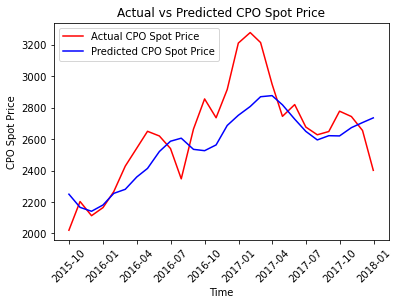

RSME =  81.73960518973219


In [25]:
k=len(df7.columns)
PRED = LSTM.predict(X_TEST)
TEMP1 = np.repeat(PRED,k, axis=-1)
PRED2 = scaler.inverse_transform(np.reshape(TEMP1,(len(PRED),k)))[:,0]

ORI = np.repeat(Y_TEST,k, axis=-1)
ORI2 = scaler.inverse_transform(np.reshape(ORI,(len(Y_TEST),k)))[:,0]

import matplotlib.pyplot as plt
plt.plot(list(TEST.iloc[3:,:].index),ORI2, color = 'red', label = 'Actual CPO Spot Price')
plt.plot(list(TEST.iloc[3:,:].index),PRED2, color = 'blue', label = 'Predicted CPO Spot Price')
plt.title('Actual vs Predicted CPO Spot Price')
plt.xlabel('Time')
plt.ylabel('CPO Spot Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

#Model Evaluation - RSME
RSME = np.sqrt(np.mean(PRED2 - ORI2)**2)
print("RSME = ",RSME)

**REMARK** : This serve as a preliminary model to demonstrate the application of multivariate LSTM model in SPO price prediction. Model performance can be improved by (1) Hyper-parameter tuning. (2) Ingestion of daily data. 

In [27]:
#Predicted CPO spot price in next three months.
PRED_N3MTH = pd.DataFrame(PRED2, columns = ['PRED'])[-3:]

#Output the result
PRED_N3MTH.to_csv("PRED_N3MTH.csv", index=False)
print("Next three months predicted spot price for CPO: ")
print(PRED_N3MTH)

Next three months predicted spot price for CPO: 
           PRED
25  2672.287598
26  2704.500977
27  2734.287598


# Productionising the Model in Server 


For the next step, production will take place in Google Colab, which will create an API to grab the data source from Git Hub repositories and ultimately output the prediction result in Google Colab server. The implemented model can be retrieved below:

Google Lab Server : <<https://colab.research.google.com/drive/1jog_Mk-V0Kznx7ohbI2Z_k8FVWmFvZeb#scrollTo=iGyKN1h_VMqa>>